# Plot transect/cruise data

This guide follows the basic plotting guide and its goal is to plot data related to oceanographic observations from cruise expeditions.
In this walkthrough, we will
1. Create a ficitious cruise track with profile data
2. Plot transects
3. Other plots

As in the basic plotting guide, throughout this guide we will use the OCIM2 grid and we will create a `dummy` modelled tracer.

In [1]:
using AIBECS, Plots
grd, _ = OCIM2.load()
fdummy(lat, lon, depth) = @. cosd(lat) * sind(lon) + sqrt(depth) / 30
dummy = fdummy(latlondepthvecs(grd)...)

┌ Warning: Over-writing registration of the datadep
│   name = AIBECS-OCIM2_CTL_He
└ @ DataDeps /Users/runner/.julia/packages/DataDeps/gbyoa/src/registration.jl:15
┌ Info: You are about to use the OCIM2_CTL_He model.
│ If you use it for research, please cite:
│ 
│ - DeVries, T., & Holzer, M. (2019). Radiocarbon and helium isotope constraints on deep ocean ventilation and mantle‐³He sources. Journal of Geophysical Research: Oceans, 124, 3036–3057. https://doi.org/10.1029/2018JC014716
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "DeVries_Holzer_2019" key.)
└ @ AIBECS.OCIM2 /Users/runner/runners/2.169.0/work/AIBECS.jl/AIBECS.jl/src/OCIM2.jl:113


200160-element Array{Float64,1}:
 0.1473082733354871
 0.14787520507677585
 0.1484347616170568
 0.1489862761222264
 0.14952909134202647
 0.15006256039330151
 0.15058604753090166
 0.1510989289053123
 0.15160059330610717
 0.15209044289033943
 ⋮
 1.6980361819651808
 1.7122377786002079
 1.6892943789530048
 1.7014040612198955
 1.7144142254394876
 1.7283093671532161
 1.7071617918226947
 1.718989643381758
 1.7316970198229305

## A fictitious cruise

For cruise data we use the [OceanographyCruises.jl](https://github.com/briochemc/OceanographyCruises.jl) package.

> **Note:**
> The purpose of the [OceanographyCruises.jl](https://github.com/briochemc/OceanographyCruises.jl) package is to provide a Julia interface for handling discrete data from cruises.
> One goal is to use it for, e.g., GEOTRACES data.
> However here we merely use it to create fictitious cruise data.

Let us create a station `Sydney` at (34°S, 152°E) and a `ALOHA` station at (22.75°N, 158°W).

In [2]:
using OceanographyCruises
Sydney = Station(name="Sydney", lat=-30, lon=156)
ALOHA = Station(name="ALOHA", lat=22.75, lon=-158)

Station ALOHA (22.8N, 158.0W)


Now let's create a range of 10 stations from `Sydney` to `ALOHA`.

In [3]:
Nstations = 10
stations = range(Sydney, ALOHA, length=Nstations, westmostlon=0)

10-element Array{OceanographyCruises.Station,1}:
 Station Sydney to ALOHA 1 (30.0S, 156.0E)

 Station Sydney to ALOHA 2 (24.1S, 161.1E)

 Station Sydney to ALOHA 3 (18.3S, 166.2E)

 Station Sydney to ALOHA 4 (12.4S, 171.3E)

 Station Sydney to ALOHA 5 (6.6S, 176.4E)

 Station Sydney to ALOHA 6 (0.7S, 181.6E)

 Station Sydney to ALOHA 7 (5.2N, 186.7E)

 Station Sydney to ALOHA 8 (11.0N, 191.8E)

 Station Sydney to ALOHA 9 (16.9N, 196.9E)

 Station Sydney to ALOHA 10 (22.8N, 202.0E)


(`westmostlon=0` ensures that the longitudes are in (0,360) to match the OCIM2 grid we use here.)

We can now construct a fictitious cruise track

In [4]:
ct = CruiseTrack(name="CruisyMcCruiseFace", stations=stations)

and check the station locations by overlaying a plot of the cruise's track over a surface map of the dummy tracer

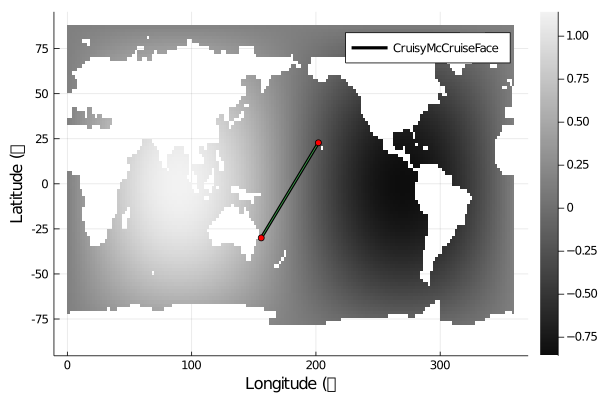

In [5]:
surfacemap(dummy, grd, color=:grays)
plotcruisetrack!(ct, markercolor=:red)

Let's create a transect of data that is almost equal to the dummy.

First, a function for creating random depths

In [6]:
function randomdepths(n, max)
    depths = cumsum(rand(n+1))
    return max * view(depths,1:n) / maximum(depths)
end
Nobs = rand(1:20, Nstations) # number of obs per station/profile
depths = [randomdepths(Nobs[i], 4000) for i in 1:Nstations]
obs = [[fdummy(st.lat, st.lon, d) .+ 0.1randn() for d in depths[i]] for (i,st) in enumerate(stations)]
profiles = [DepthProfile(station=st, depths=depths[i], values=obs[i]) for (i,st) in enumerate(stations)]

t = Transect(tracer="dummy", cruise=ct.name, profiles=profiles)

## Transects

### Zonal transect

We can plot the modelled `dummy` data along the `ct` cruise track in the zonal directiion (along longitudes) with

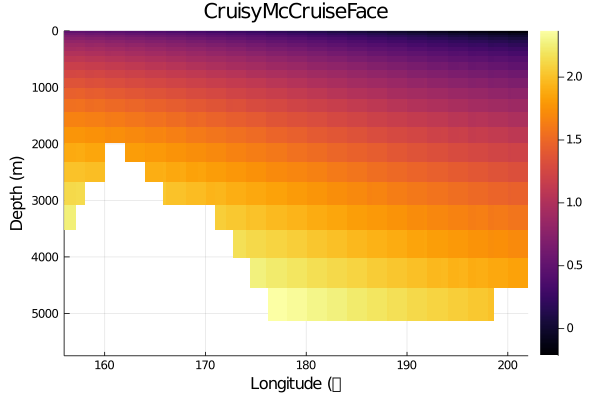

In [7]:
zonaltransect(dummy, grd, ct=ct)

If we want the observations transect on top of it

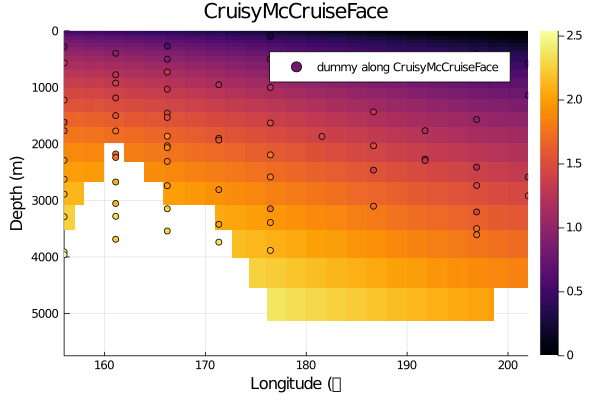

In [8]:
zonalscattertransect!(t)

### Meridional transect

Same for meridional transects (along latitude)

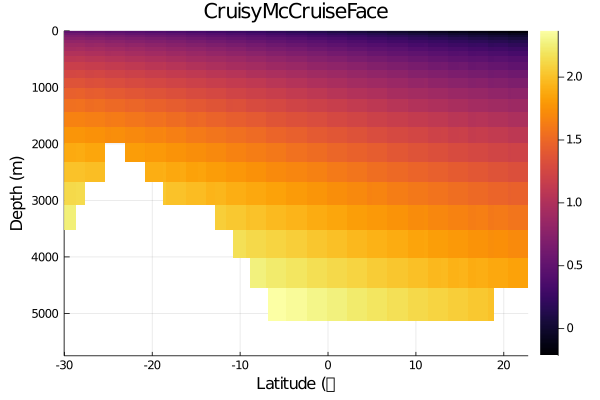

In [9]:
meridionaltransect(dummy, grd, ct=ct)

and

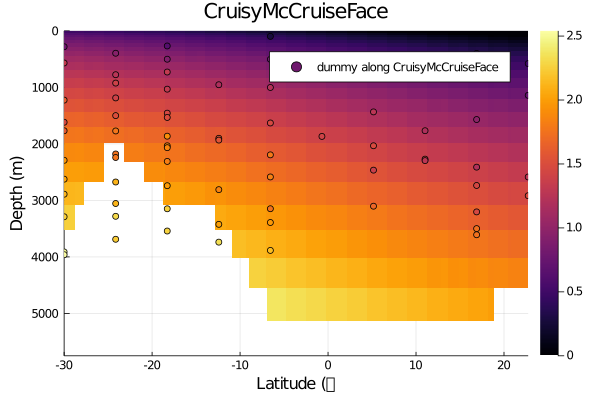

In [10]:
meridionalscattertransect!(t)

If you have the GEOTRACESTools package installed and the GEOTRACES data installed at the right location, you can instead plot real data with something like

```julia
using GEOTRACESTools
zonalscattertransect(tracertransect("Fe", "GA02"))
```

However, this cannot be showcased online because GEOTRACES decided its data should "not be distributed to third parties".

## Other plots

Plots the modelled ratio of two modelled tracers at a given station.

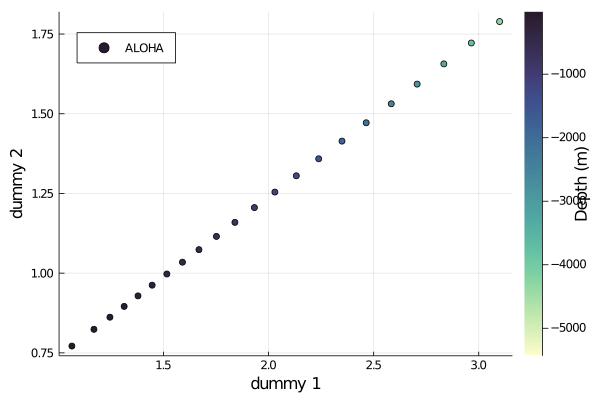

In [11]:
dummy1 = cosd.(latvec(grd)) + sqrt.(depthvec(grd)) / 30
dummy2 = cosd.(2latvec(grd)) + 0.5sqrt.(depthvec(grd)) / 30
ratioatstation(dummy1, dummy2, grd, ALOHA, xlabel="dummy 1", ylabel="dummy 2")

This can be useful to compare stoichiometric ratios at different stations.

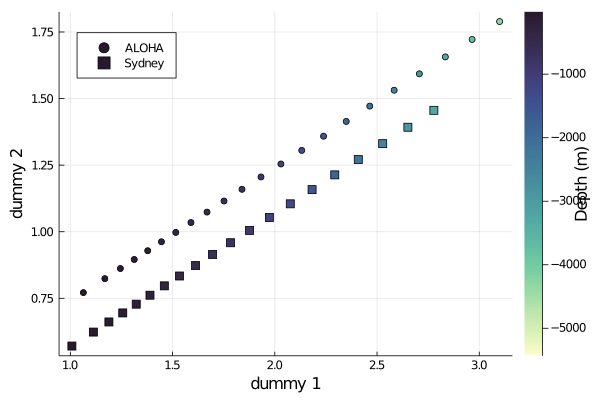

In [12]:
ratioatstation!(dummy1, dummy2, grd, Sydney, marker=:square)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*